In [1]:
import os
# os.chdir('/Users/Sinead/DC-project/')
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
import script
%matplotlib inline
import plotly 
plotly.offline.init_notebook_mode()
import find_eyes_reshape as fer
import nibabel as nib
import tonp_Shijia

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
PathDicom = '/Users/fair00542/Desktop/Sinead/DC-Project-Images/original/Sample5/S5_Post-op.nrrd'


# Threshold the CT scan

In [3]:
if PathDicom.endswith('.nii') or PathDicom.endswith('.nii.gz'):
    array, ConstPixelSpacing, _ = tonp_Shijia.nifti2np(PathDicom)
    bone = tonp_Shijia.thresholdnp(array, 1100, 1500)
    softtissue  = tonp_Shijia.thresholdnp(array, 0, 80)

elif PathDicom.endswith('.dcm'):
    array, ConstPixelSpacing, _ = tonp_Shijia.dicom2np(PathDicom)
    bone = tonp_Shijia.thresholdnp(array, 1100, 1500)
    softtissue  = tonp_Shijia.thresholdnp(array, 0, 80)

elif PathDicom.endswith('.nrrd'):
    array, ConstPixelSpacing, _ = tonp_Shijia.nrrd2np(PathDicom)
    bone = tonp_Shijia.thresholdnp(array, 1100, 1500)
    softtissue  = tonp_Shijia.thresholdnp(array, 0, 80)

# Reshape the CT scan for circle detection for the eyes

In [7]:
# reshape the arrays - don't run this twice
array_bone = script.reshape(bone, ConstPixelSpacing, 220, 160, array.shape[0], array.shape[2])
array_eyes = script.reshape(softtissue, ConstPixelSpacing, 220, 160, array.shape[0], array.shape[2])
array = script.reshape(array, ConstPixelSpacing, 220, 160, array.shape[0], array.shape[2])

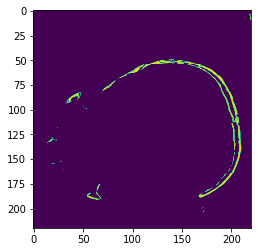

In [31]:
plt.imshow(array_bone[:,:,80]) # just checking that the image imported okay
plt.show()

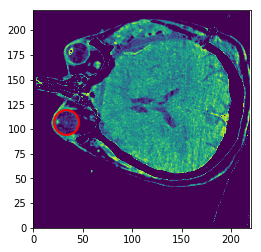

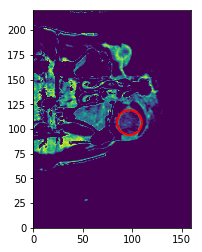

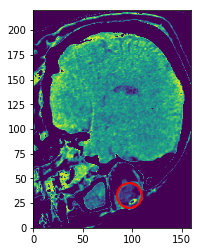

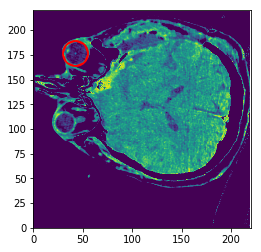

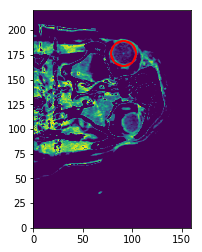

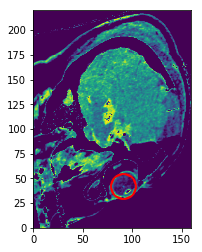

In [16]:
H, edges, data, hist_data_2c  = fer.hist3d_all(array_eyes)
ranges_1, ranges_2, certainty = fer.ranges(H,edges)
c1,c2 = fer.coords(hist_data_2c, ranges_1, ranges_2)
fer.check_coords(c1,c2,array_eyes) # this checks that the eyes were correctly found

In [22]:
c1, c2
# coordinates of eyes in original coordinate system
c1original = np.divide(c1, ConstPixelSpacing)
c2original = np.divide(c2, ConstPixelSpacing)

In [25]:
c1original, c2original

(array([ 236.65024631,   73.73399015,  139.082239  ]),
 array([ 392.06896552,   94.82758621,  130.62556948]))

# Up to here then try to find the brainstem

In [26]:
angle1, angle2 = fer.angles_from_eyes(c1,c2) # get the 
array_bone1, array_bone2 = fer.correct_skews(angle1,angle2,array_bone)
array_eyes1, array_eyes2 = fer.correct_skews(angle1,angle2,array_eyes)
array_visual1, array_save = fer.correct_skews(angle1,angle2,array)

In [27]:
angles, xcentroids, ycentroids, xmajor_axis_points, ymajor_axis_points = script.ellipses(array_bone2)

Starting ellipse fitting


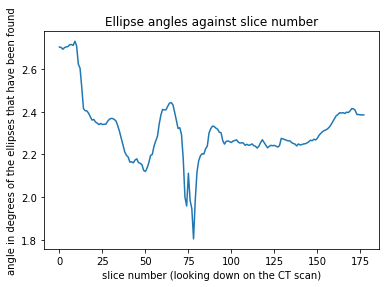

In [28]:
slices, slice_angles = script.select_ellipses_range(angles)
plt.plot(angles)
plt.xlabel('slice number (looking down on the CT scan)')
plt.ylabel('angle in degrees of the ellipses that have been found')
plt.title('Ellipse angles against slice number')
plt.show()

In [29]:
head_angles = slice_angles
head_x = [xcentroids[i] for i in slices] 
head_y = [ycentroids[i] for i in slices] 

In [30]:
a,b,c,d = script.find_plane_from_ellipses(array_bone2,array_eyes2, slices, head_x, head_y, head_angles)
# 0 = ax + by + cz + d

# Saving Midplane and Sample

In [ ]:
samplename = 'sample'
img = nib.Nifti1Image(array_visual2, np.eye(4))
nib.save(img, '{}.nii.gz'.format(samplename)) # downloading new scan to go with midplane

midplanename = 'midplane'

shape = img.array_visual2.shape
mask = -1000*np.ones((shape))
x = np.arange(0,shape[0],1)
z = np.linspace(0,shape[2],shape[0])

xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
y = yy.astype(int)

for k in range(shape[1]):
    for i in range(shape[2]):
        mask[y[k][i]-1:y[k][i]+1, k, i] = 1000
img = nib.Nifti1Image(mask, np.eye(4))
nib.save(img, '{}.nii.gz'.format(midplanename)) # downloading midplane


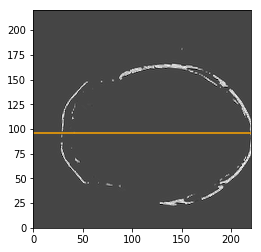

In [37]:
from matplotlib.colors import LinearSegmentedColormap
import pylab
cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0,0,0),(0.2, 0.2, 0.2),(0.3, 0.3, 0.3), (0.4, 0.4, 0.4),(0.5, 0.5, 0.5), (0.6,0.6,0.6),(0.7, 0.7, 0.7), (0.8, 0.8, 0.8), (0.9, 0.9, 0.9),(0.8, 0.8, 0.8),(0.7, 0.7, 0.7),(0.8, 0.8, 0.8),(0.9, 0.9, 0.9),(1,1,1)), N=256, gamma=1.0)
slice_no = 106
slice_ = array_bone2[:,:,slice_no]
plt.clf()
plt.imshow(slice_, cmap=cmap1, interpolation='nearest')
x = np.linspace(0,slice_.shape[0], 2)
y = (d-c*slice_no-a*x)/b
plt.xlim([0,array_visual.shape[0]])
plt.ylim([0,array_visual.shape[1]])
plt.plot(x,y, color='orange')
plt.show()

In [45]:
script.visualise_single(array_eyes2, a,b,c,d, 100)